# 1회차

# Introduction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Load and check data

## Load data

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
IDtest = test['PassengerId']

## Outlier detection

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile(75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices more than 2 outliers
        outlier_indices.extend(outlier_list_col)
    
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers
    # detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train,2,['Age', 'SibSp', 'Parch', 'Fare'])

아웃라이어가 예측에 큰 영향을 미칠 수 있기 때문에, Tukey method(Tukey JW. 1977)을 사용하여 아웃라이어를 찾습니다. IQR 에서 outlier step만큼 떨어져 있을 시 아웃라이어로 판정합니다.

데이터의 수치형 피처에서 아웃라이어를 찾습니다. 

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 찾았습니다. 27, 88, 341번 승객은 높은 티켓 요금을 지불했고 나머지 7명은 많은 SibSP을 가지고 있습니다.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

훈련용과 검증용 데이터셋을 조인시켜 추후 피처 엔지니어링에서 같은 수의 피처를 얻게 했습니다.

##  check for null and missing values

In [7]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

#check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin 피처가 많은 결측값을 가지고 있습니다.

Survived는 테스트 데이터셋을 조인시켜 NaN값이 생긴 것입니다.

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summary and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical values

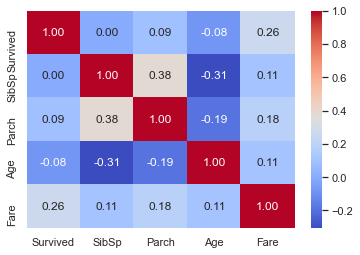

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

오직 Fare 피처만 생존율과 관련이 있어 보입니다.

다른 피처는 유용하지 않아보입니다. 좀더 자세하게 살펴보겠습니다.

### SibSp

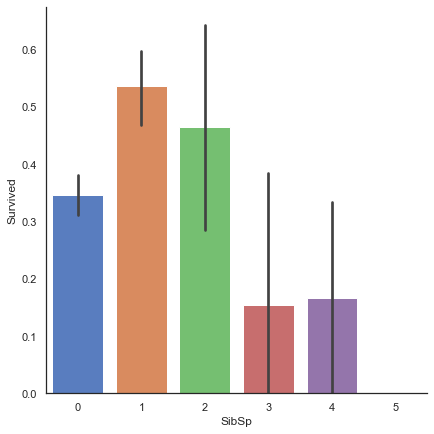

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x = 'SibSp', y='Survived', data = train, kind='bar', size=6, palette='muted')

탑승객이 많은 형제자매나 배우자를 태우고 탈수록 생존율이 감소합니다.

혼자 탑승한 사람 또는 두명과 탄사람은 생존율이 높습니다.

### Parch

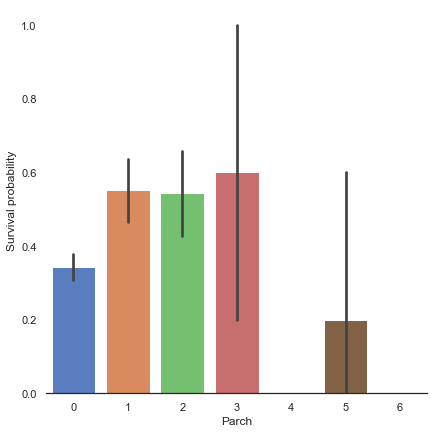

In [14]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

가족이 3명 이하일때 생존율이 혼자일때보다 높습니다.

### Age

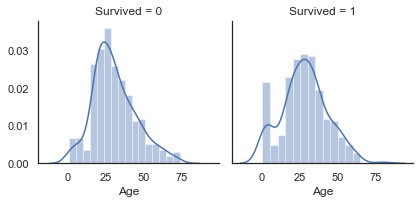

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

 생존자와 사망자의 나이 분포가 같지 않습니다. 게다가 생존자 중 어린 탑승객의 생존율이 매우 높게 나타납니다. 60-80세의 탑승객의 생존율은 낮습니다.
 
Age가 생존율과 상관관계가 없다 해도, 생존 가능성이 존재하는 승객의 연령 범주가 있음을 알 수 있습니다.

아주 어린 승객들은 생존할 수 있는 더 많은 기회를 가지고 있습니다.

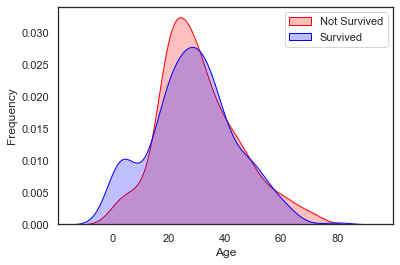

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 그래프를 비교했을 때, 0-5세 사이에서 생존율이 높게 나옴을 알 수 있습니다.

### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

하나의 결측값을 중위수로 채웠습니다.

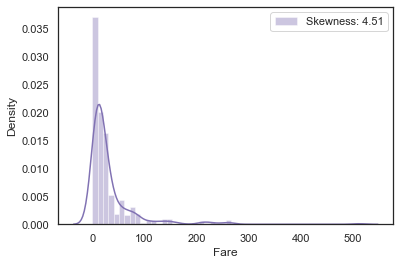

In [19]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

Fare의 분포는 매우 좌측으로 편향되어 있습니다. 따라서 이를 조정하기 위해 Fare에 log를 취해 skew을 낮추겠습니다.

In [20]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

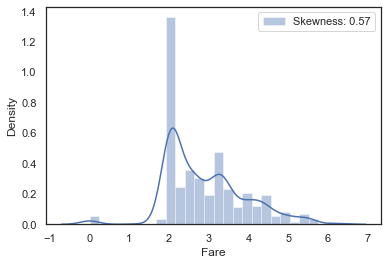

In [21]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

skew가 매우 크게 감소한 것을 볼 수 있습니다.

## Categorical values

### Sex

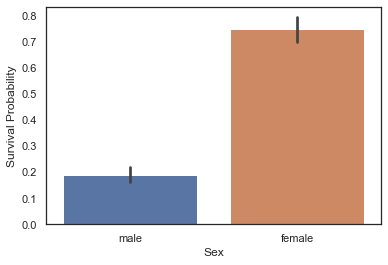

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존율이 매우 작습니다.

생존을 예측할 때 성별은 매우 중요한 피처가 될 것 같습니다.

### Pclass

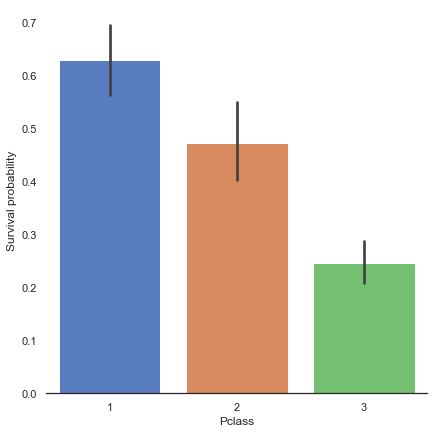

In [24]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar',size=6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

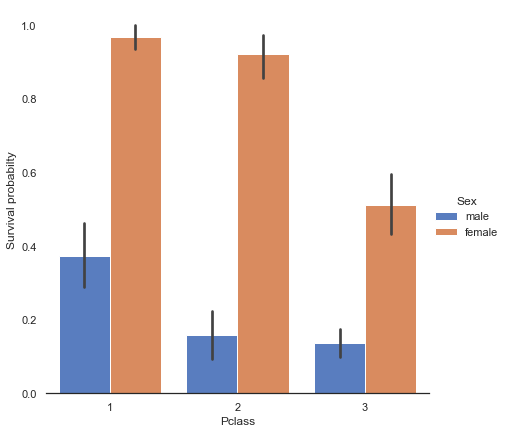

In [25]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probabilty')

클래스1의 승객이 남여 모두 생존율이 가장 높습니다.

### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [28]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측치를 가장 많이 관측된 S로 채웠습니다.

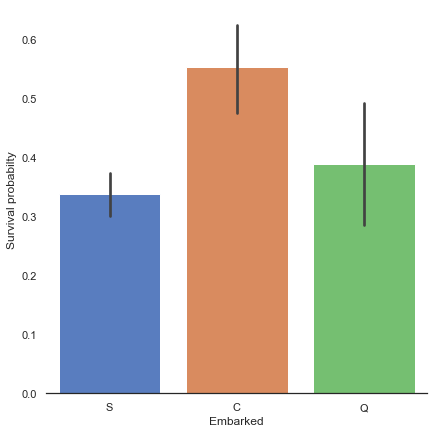

In [29]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probabilty')

C에서 탑승한 사람의 생존율이 높습니다.

Pclass 1의 탑승객이 C에서 많이 탔을 것 같다는 추론을 해볼 수 있습니다.

한번 비교해봅시다.

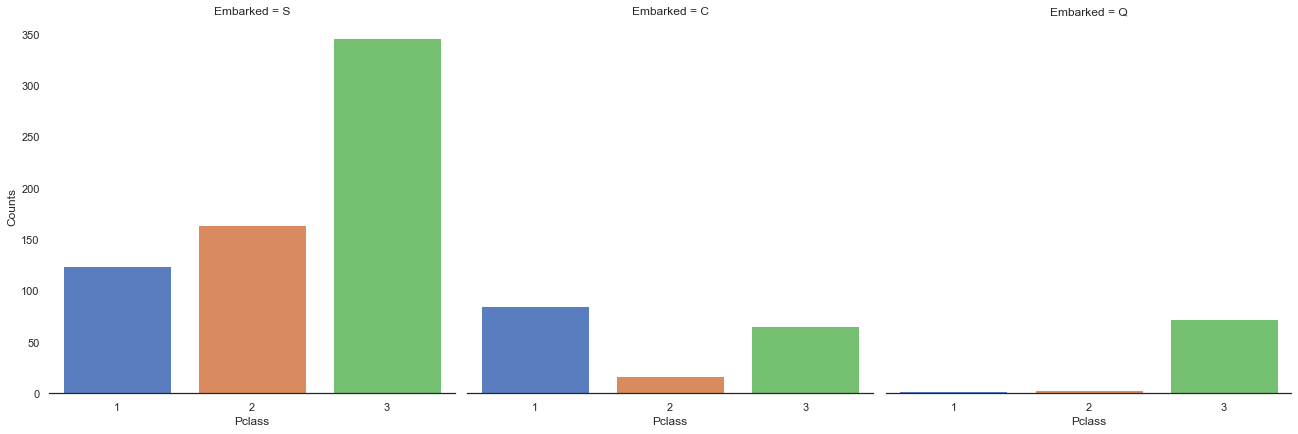

In [32]:
g = sns.catplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Counts')

클래스 3의 탑승객은 주로 S와 Q에서 탑승했고, 클래스 1의 탑승객은 C에서 많이 탑승했습니다. 클래스 1의 비율이 높으므로 C의 생존율이 높은 것과 직결됩니다.

클래스 1의 탑승객이 구조에서 우선순위가 있었던 것 같습니다.

# Filling Missing Values

## Age

Age 컬럼에는 256개의 결측값이 존재합니다.

어린아이의 생존율이 높기 때문에 연령의 특징을 유지하면서 결측값을 바꾸는 것이 좋을 것 같습니다.

이를 위해 Age와 가장 상관관계가 있는 특징들을 살펴보겠습니다.

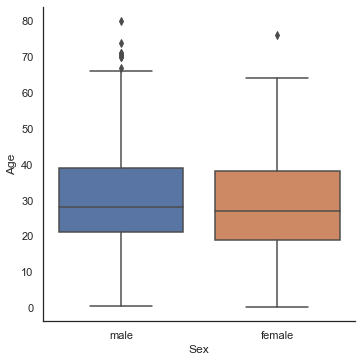

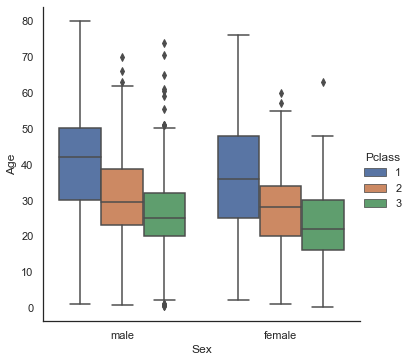

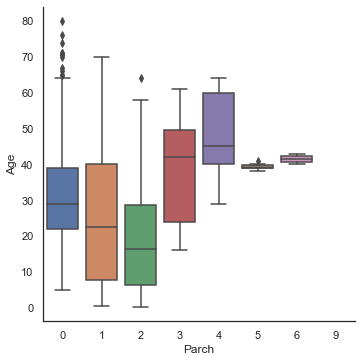

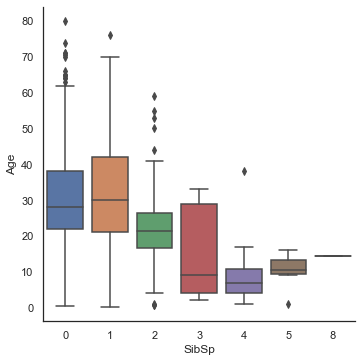

In [34]:
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

연령 분포는 남성과 여성이 동일한 것으로 보이므로 성별은 연령 예측에 도움이 되지 않습니다.

하지만, 1등석 승객은 2,3등석 승객보다 나이가 많습니다.

또한 승객이 부모/자식을 많이 가질수록 나이가 많고, 동생/배우자가 많을 수록 나이가 적습니다.

In [35]:
dataset['Sex'] = dataset['Sex'].map({'male': 0,'female': 1})

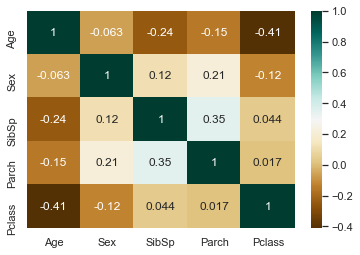

In [36]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

히트맵을 보면 나이는 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 음의 상관관계가 있습니다.

Parch 그래프에서 부모/자녀 수에 따라 나이가 증가했지만 상관관계가 음으로 나왔습니다.

SibSp, Parch, Pclass을 사용해서 중위수로 나이의 결측값을 채우겠습니다.

In [37]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

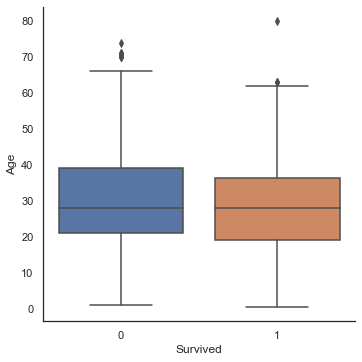

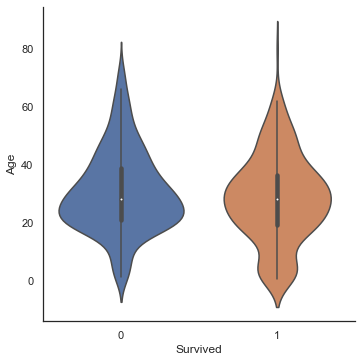

In [39]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

생존자와 사망자의 연령 중위수 차이가 많이 나지 않습니다.

그러나 바이올린플롯을 봤을 때 여전히 어린이의 생존율이 높은 것으로 나타납니다.

# Feature engineering

## Name/Title

In [40]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름 피처에는 승객의 직함에 대한 정보가 포함되어 있습니다.

In [41]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

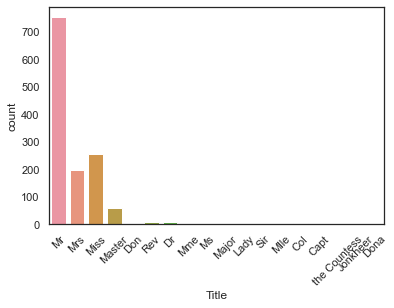

In [43]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17개의 타이틀이 존재합니다. 이를 4개의 범주로 바꾸겠습니다.

In [44]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss': 1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

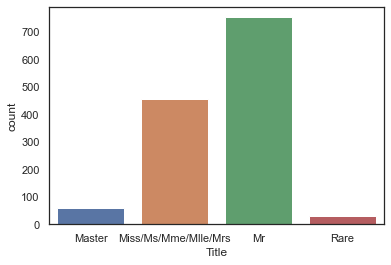

In [48]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

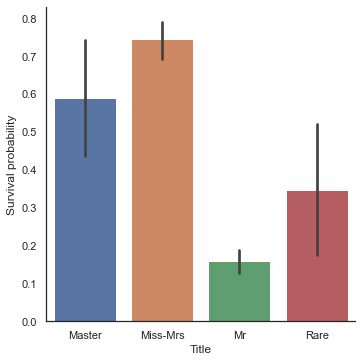

In [49]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival probability')

"Women and children first"

Rare 타이틀을 가진 탑승객이 Mr 탑승객보다 생존율이 높습니다.

In [50]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

## Family size

가족이 많을 수록 구성원을 모두 찾느라 생존율이 낮을 것이라는 추측을 할 수 있습니다. Fsize 피처를 만들어 SibSp와 Parch 그리고 탑승객을 더하겠습니다.

In [52]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

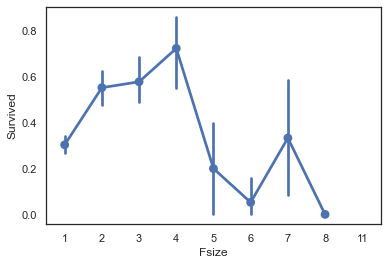

In [54]:
g = sns.pointplot(x='Fsize', y='Survived', data=dataset)

가족 구성원의 수가 생존율에 중요한 영향을 미치는 것 같습니다.

마찬가지로 이도 4가지 카테고리로 분류하겠습니다.

In [55]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

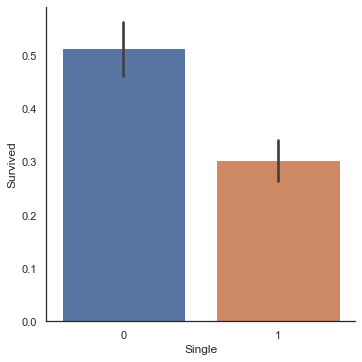

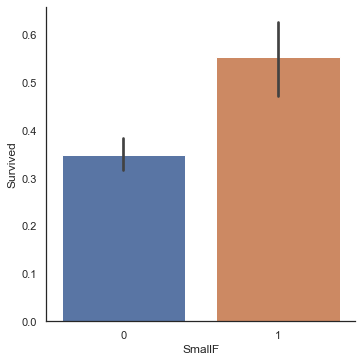

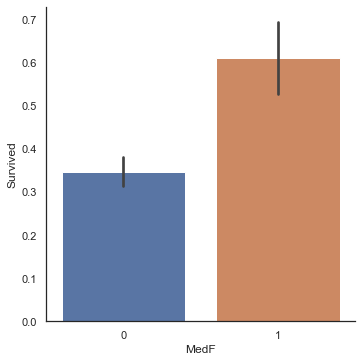

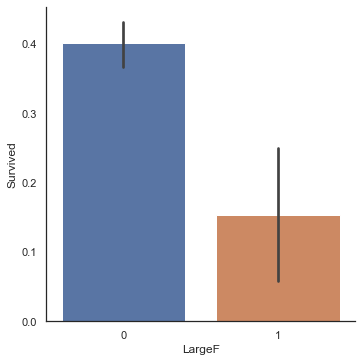

In [56]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')

SmallF, MedF 가 Single보다 생존율이 높고 LargeF가 제일 낮습니다.

In [57]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [58]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


22개의 피처를 얻었습니다.

## Cabin

In [59]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [60]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [62]:
dataset['Cabin'].isnull().sum()

1007

Cabin 피처에 292개의 값과 1007개의 결측값이 존재합니다.

cabin을 배정받지 않은 승객이 결측값으로 나온 것 같습니다.

In [63]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [65]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

Cabin이 타이타닉에서 승객이 어디에 위치했는지 대략적으로 짐작해볼 수 있습니다.

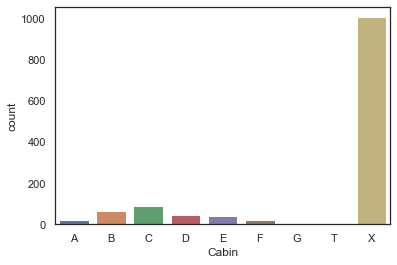

In [66]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

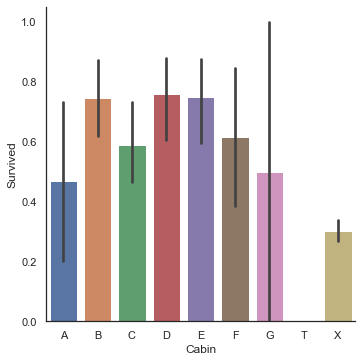

In [68]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])

객실을 가진 승객 수가 적기 때문에 생존율은 중요한 표준 편차를 가지고 있고 우리는 데스크에서 생존율을 구분할 수 없습니다.

하지만 객실을 가진 승객들이 없는 승객들보다 생존율이 높은 것을 알 수 있습니다.

In [69]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## Ticket

In [70]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 공유하는 티켓이 함께 배치된 선실에 예약될 수 있습니다. 선체 내에 실제로 선실을 배치할 수 있습니다.

같은 접두사를 가진 티켓은 유사한 등급과 생존율을 가질 수 있습니다.

따라서 티켓 피처를 티켓 접두사로 바꾸겠습니다.

In [71]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [72]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [74]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [75]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [77]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [80]:
# train/test 데이터셋 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [81]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

## Simple modeling

### Cross validate models

In [82]:
kfold = StratifiedKFold(n_splits=10)

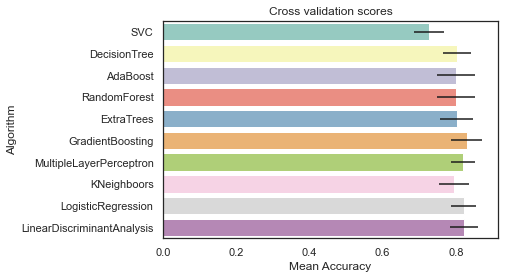

In [86]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_results in cv_results:
    cv_means.append(cv_results.mean())
    cv_std.append(cv_results.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 'Algorithm': ['SVC', "DecisionTree", "AdaBoost", 
"RandomForest", "ExtraTrees", "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

SVC, AdaBoost, RandomForest, ExtraTrees 그리고 GradientBoosting 분류기를 사용하겠습니다.

### Hyperparameter tunning for best models

GridSearch을 활용해 분류기를 최적화하겠습니다.

n_jobs 파라미터를 4로 설정하겠습니다.

In [87]:
# AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 2], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid= ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   12.1s finished


In [88]:
gsadaDTC.best_score_

0.8241317671092953

In [89]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap':[False], 'n_estimators': [100, 300], 'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8297369765066394

In [90]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {'max_depth': [None], 'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100, 300], 'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best Score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8342951991828397

In [92]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]
}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   52.8s finished


0.8331716036772218

In [93]:
### SVC classifier
SVMC = SVC(probability = True)
svc_param_grid = {'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C':[1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best Score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   44.0s finished


0.8331332992849847

### Plot learning curves

학습 곡선은 훈련 셋에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인할 수 있는 좋은 방법입니다.

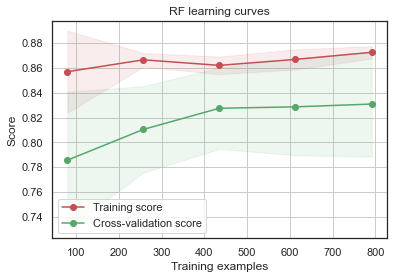

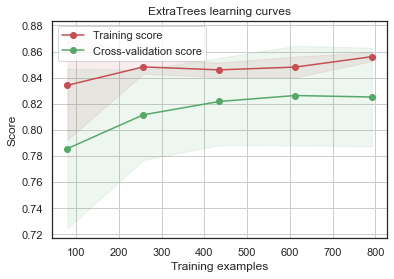

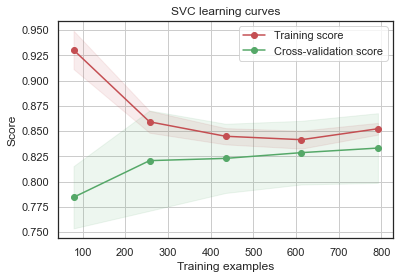

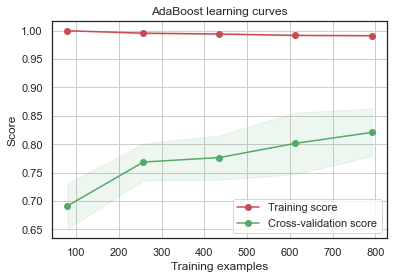

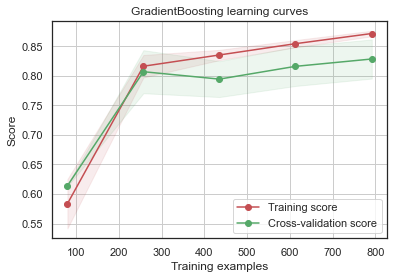

In [94]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

GradientBoosting과 Adaboost 분류기는 과적합인 것으로 판단됩니다.

두 분류기의 교차검증곡선은 데이터셋이 늘어날 수록 값이 증가합니다.

SVC와 ExtraTree 분류기가 예측을 일반화하기에 적합해보입니다.

### Feature importance of tree based classifiers

승객의 생존유무를 측정하는데 더 중요한 피처를 살펴보기 위해 4개의 tree 기반 분류기를 사용하여 피처의 중요성을 도시하겠습니다.

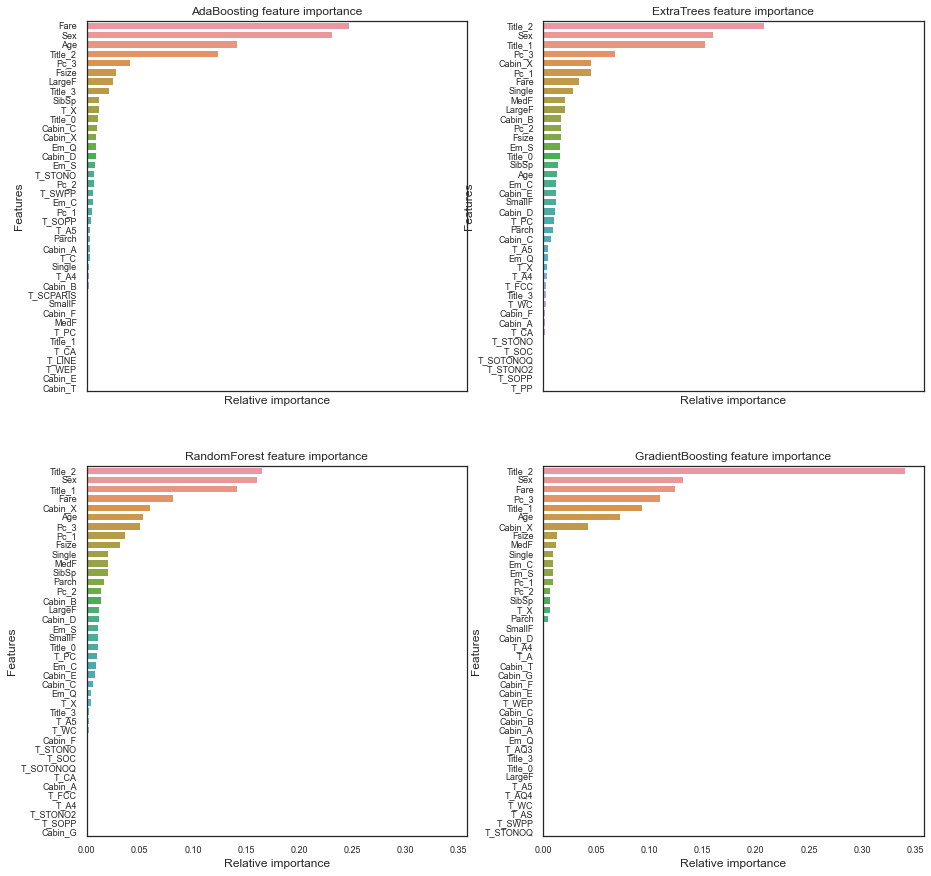

In [97]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex='all', figsize=(15, 15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' feature importance')
        nclassifier += 1
        

4개의 분류기가 다르게 상위 피처를 분류했습니다. 분류기마다 예측을 같은 피처로 하지 않았음을 의미합니다. 그럼에도 불구하고, 공통적인 중요한 피처를 꼽았습니다.(Fare, Title_2, Age, Sex)

Title_2는 Mrs/Mlle/Mme/Miss/Ms 입니다 이는 Sex와 상관관계가 큽니다.

이렇게 정리하겠습니다.
- Pc_1, Pc_2, Pc_3 과 Fare은 승객들의 일반적인 사회적 지위를 나타냅니다.
- Sex와 Title_2, Title_3는 성별을 나타냅니다.
- Age와 Title_1(Master)은 승객의 연령을 나타냅니다.
- Fsize, LargeF, MedF, Single은 승객의 가족수를 나타냅니다.

**4 분류기의 feature importance에 따르면, 생존 예측은 배에서 위치보다 승객들의 연령, 성별, 가족 규모, 사회적 지위 등과 더 관련있어 보입니다.**

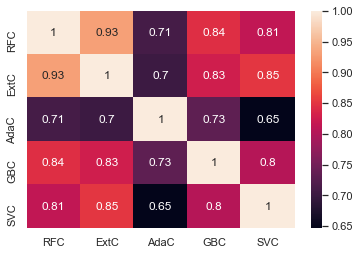

In [98]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='AdaC')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

# 모든 분류기의 결과 통합
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g=sns.heatmap(ensemble_results.corr(), annot=True)

Adaboost을 다른 분류기와 비교할 때를 제외하고는 5개의 분류기에 대한 예측이 매우 유사한 것 같습니다.

5개의 분류기는 같은 예측값을 제공하지만 몇 가지 차이가 있습니다. 이러한 5개의 분류기 예측 간의 차이는 모델을 조합하기에 충분합니다.

## Ensemble modeling

### Combining models

5개의 분류기에서 나오는 예측들을 조합하기 위해 voting classifier을 선택했습니다.

각 투표의 확률을 고려하여 'soft' 주장을 투표 매개변수에 전달하겠습니다.

In [99]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## Prediction

### Predict and Submit results

In [100]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv', index=False)

# 2회차

# Introduction

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Load and check data

## Loda data

In [169]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
IDtest = test['PassengerId']

## Outlier detection

In [170]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices more than 2 outliers
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

아웃라이어가 예측에 큰 영향을 미칠 수 있기 때문에, Tukey method(Tukey JW. 1977)을 사용하여 아웃라이어를 찾습니다. IQR 에서 outlier step만큼 떨어져 있을 시 아웃라이어로 판정합니다.

데이터의 수치형 피처에서 아웃라이어를 찾습니다.

In [171]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 찾았습니다. 27, 88, 341번 승객은 높은 티켓 요금을 지불했고 나머지 7명은 많은 SibSP을 가지고 있습니다.

In [172]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## joining train and test set

In [173]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

훈련용과 검증용 데이터셋을 조인시켜 추후 피처 엔지니어링에서 같은 수의 피처를 얻게 했습니다.

## check for null and missing values

In [174]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin 피처가 많은 결측값을 가지고 있습니다.

Survived는 테스트 데이터셋을 조인시켜 NaN값이 생긴 것입니다.

In [175]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 65.4+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [176]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [177]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [178]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical values

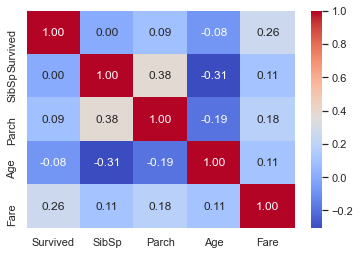

In [179]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

오직 Fare 피처만 생존율과 관련이 있어 보입니다.

다른 피처는 유용하지 않아보입니다. 좀더 자세하게 살펴보겠습니다.

### SibSp

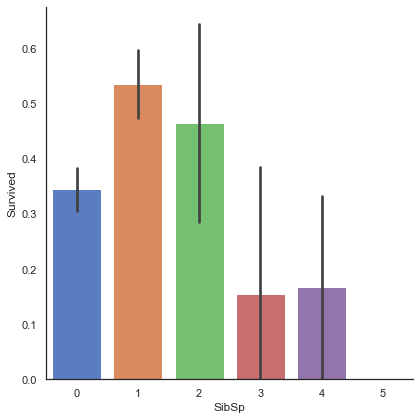

In [180]:
# Explore SibSp feature vs Survived
g = sns.catplot(x = 'SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')

탑승객이 많은 형제자매나 배우자를 태우고 탈수록 생존율이 감소합니다.

혼자 탑승한 사람 또는 두명과 탄사람은 생존율이 높습니다.

### Parch

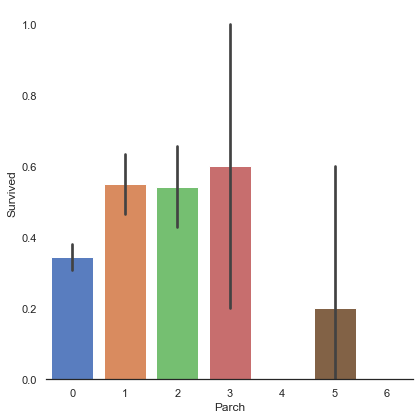

In [181]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)

가족이 3명 이하일때 생존율이 혼자일때보다 높습니다.

### Age

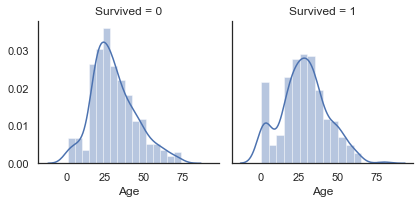

In [182]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

생존자와 사망자의 나이 분포가 같지 않습니다. 게다가 생존자 중 어린 탑승객의 생존율이 매우 높게 나타납니다. 60-80세의 탑승객의 생존율은 낮습니다.

Age가 생존율과 상관관계가 없다 해도, 생존 가능성이 존재하는 승객의 연령 범주가 있음을 알 수 있습니다.

아주 어린 승객들은 생존할 수 있는 더 많은 기회를 가지고 있습니다.

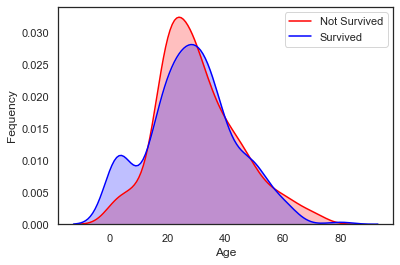

In [183]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Fequency')
g = g.legend(['Not Survived', 'Survived'])

두 그래프를 비교했을 때, 0-5세 사이에서 생존율이 높게 나옴을 알 수 있습니다.

### Fare

In [184]:
dataset['Fare'].isnull().sum()

1

In [185]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

하나의 결측치를 중위수로 대체합니다.

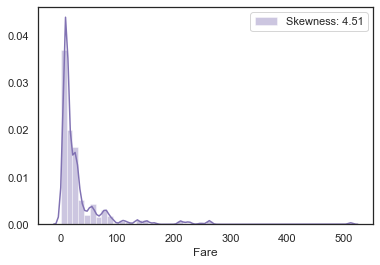

In [186]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

Fare의 분포는 매우 좌측으로 편향되어 있습니다. 따라서 이를 조정하기 위해 Fare에 log를 취해 skew을 낮추겠습니다.

In [187]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

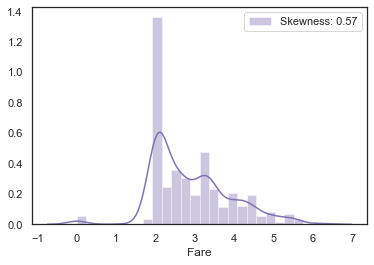

In [188]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

skew가 매우 크게 감소한 것을 볼 수 있습니다.

## Categorical values

### Sex

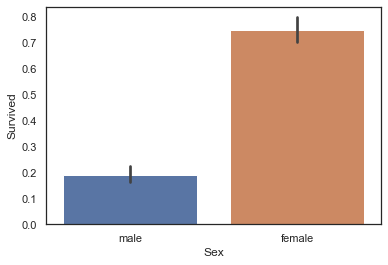

In [189]:
g = sns.barplot(x='Sex', y='Survived', data=train)

In [190]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존율이 매우 작습니다.

생존을 예측할 때 성별은 매우 중요한 피처가 될 것 같습니다.

### Pclass

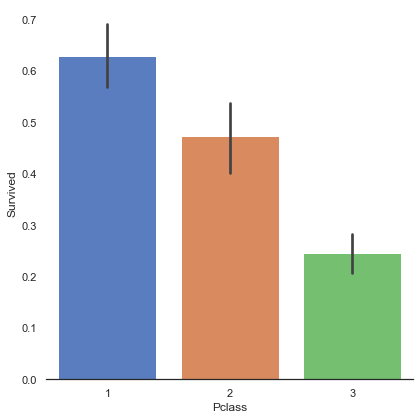

In [191]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)

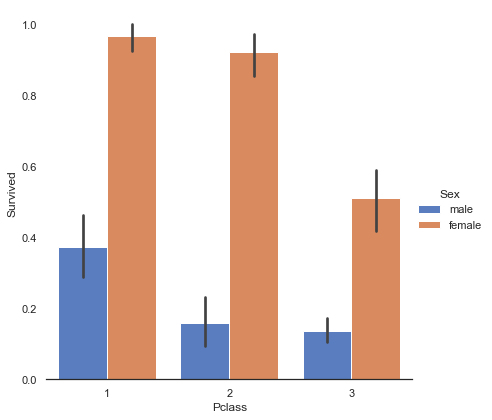

In [192]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)

클래스1의 승객이 남여 모두 생존율이 가장 높습니다.

### Embarked

In [193]:
dataset['Embarked'].isnull().sum()

2

In [194]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [195]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측치를 가장 많이 관측된 S로 채웠습니다.

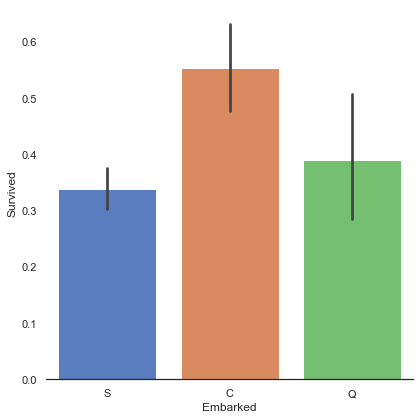

In [196]:
g = sns.catplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)

C에서 탑승한 사람의 생존율이 높습니다.

Pclass 1의 탑승객이 C에서 많이 탔을 것 같다는 추론을 해볼 수 있습니다.

한번 비교해봅시다.

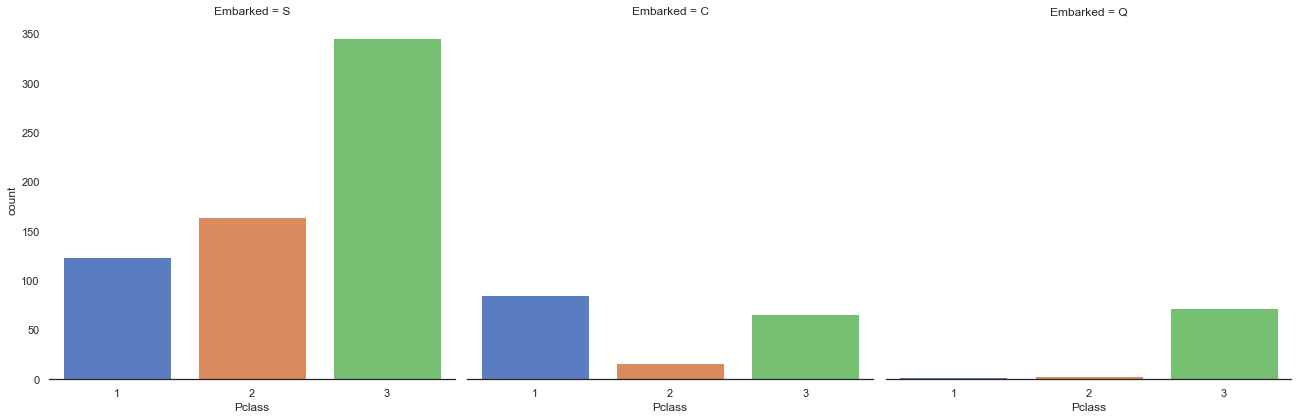

In [197]:
g = sns.catplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)

클래스 3의 탑승객은 주로 S와 Q에서 탑승했고, 클래스 1의 탑승객은 C에서 많이 탑승했습니다. 클래스 1의 비율이 높으므로 C의 생존율이 높은 것과 직결됩니다.

클래스 1의 탑승객이 구조에서 우선순위가 있었던 것 같습니다.

# Filling Missing Values

## Age

Age 컬럼에는 256개의 결측값이 존재합니다.

어린아이의 생존율이 높기 때문에 연령의 특징을 유지하면서 결측값을 바꾸는 것이 좋을 것 같습니다.

이를 위해 Age와 가장 상관관계가 있는 특징들을 살펴보겠습니다

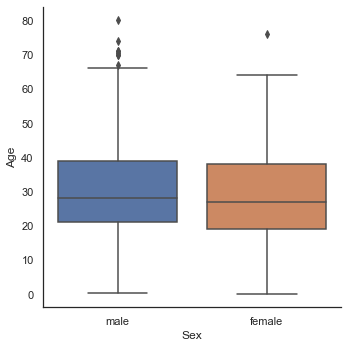

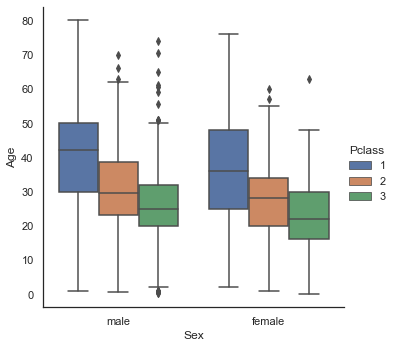

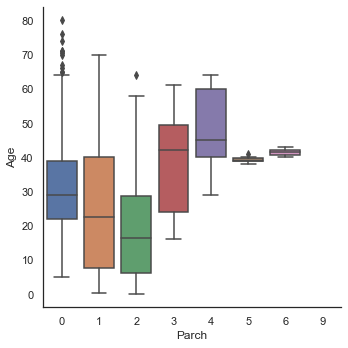

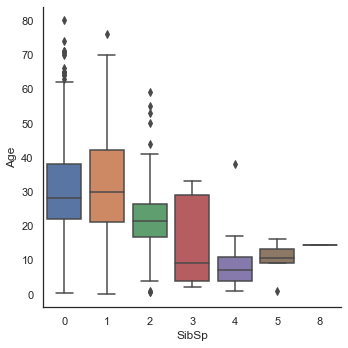

In [198]:
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

연령 분포는 남성과 여성이 동일한 것으로 보이므로 성별은 연령 예측에 도움이 되지 않습니다.

하지만, 1등석 승객은 2,3등석 승객보다 나이가 많습니다.

또한 승객이 부모/자식을 많이 가질수록 나이가 많고, 동생/배우자가 많을 수록 나이가 적습니다.

In [199]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

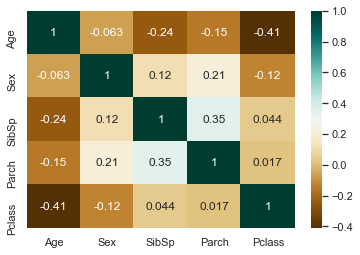

In [200]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

히트맵을 보면 나이는 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 음의 상관관계가 있습니다.

Parch 그래프에서 부모/자녀 수에 따라 나이가 증가했지만 상관관계가 음으로 나왔습니다.

SibSp, Parch, Pclass을 사용해서 중위수로 나이의 결측값을 채우겠습니다.

In [201]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

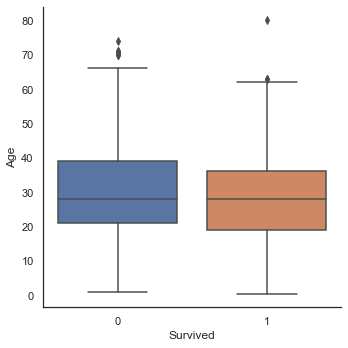

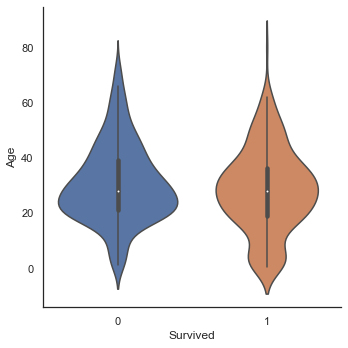

In [202]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

생존자와 사망자의 연령 중위수 차이가 많이 나지 않습니다.

그러나 바이올린플롯을 봤을 때 여전히 어린이의 생존율이 높은 것으로 나타납니다.

# Feature engineering 

## Name/Title

In [203]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름 피처에는 승객의 직함에 대한 정보가 포함되어 있습니다.

In [204]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

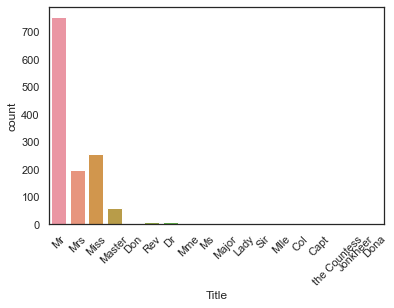

In [205]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17개의 타이틀이 존재합니다. 이를 4개의 범주로 바꾸겠습니다.

In [206]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

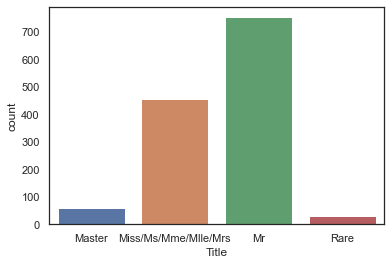

In [207]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

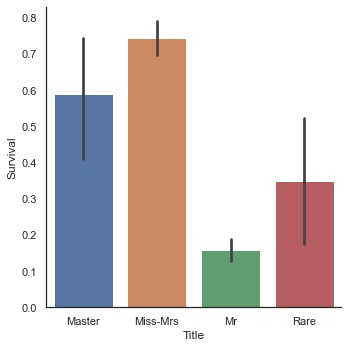

In [208]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival')

"Women and children first"

Rare 타이틀을 가진 탑승객이 Mr 탑승객보다 생존율이 높습니다.

In [209]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

## FamilySize

가족이 많을 수록 구성원을 모두 찾느라 생존율이 낮을 것이라는 추측을 할 수 있습니다. Fsize 피처를 만들어 SibSp와 Parch 그리고 탑승객을 더하겠습니다.

In [210]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

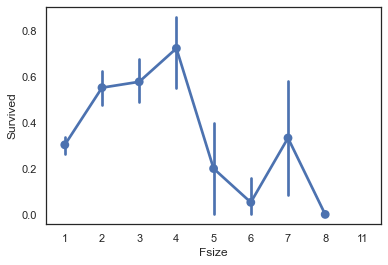

In [211]:
g = sns.pointplot(x='Fsize', y='Survived', data=dataset)

가족 구성원의 수가 생존율에 중요한 영향을 미치는 것 같습니다.

마찬가지로 이도 4가지 카테고리로 분류하겠습니다.

In [212]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

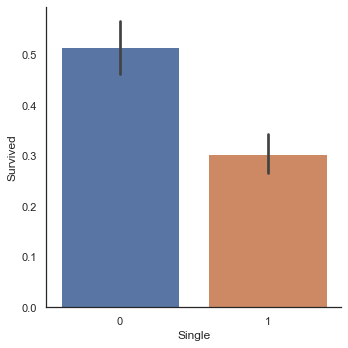

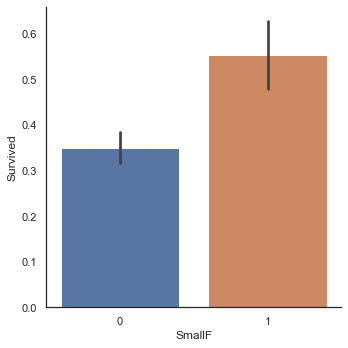

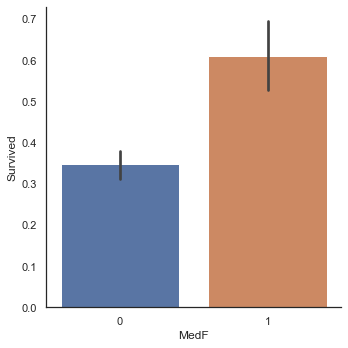

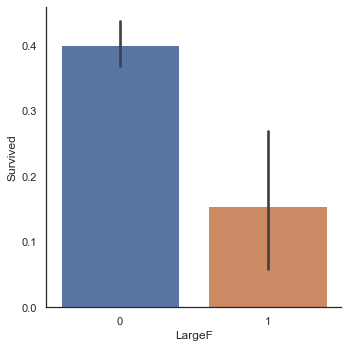

In [213]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')

SmallF, MedF 가 Single보다 생존율이 높고 LargeF가 제일 낮습니다.

In [214]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [215]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


22개의 피처를 얻었습니다.

## Cabin

In [216]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [217]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [218]:
dataset['Cabin'].isnull().sum()

1007

Cabin 피처에 292개의 값과 1007개의 결측값이 존재합니다.

cabin을 배정받지 않은 승객이 결측값으로 나온 것 같습니다.

In [219]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [220]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

Cabin이 타이타닉에서 승객이 어디에 위치했는지 대략적으로 짐작해볼 수 있습니다.

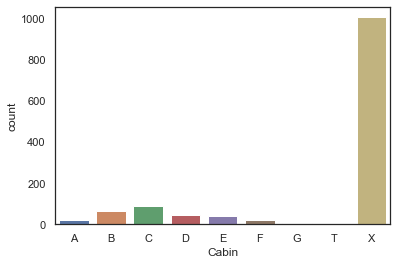

In [221]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

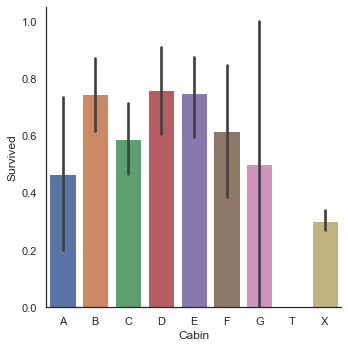

In [222]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])

객실을 가진 승객 수가 적기 때문에 생존율은 중요한 표준 편차를 가지고 있고 우리는 데스크에서 생존율을 구분할 수 없습니다.

하지만 객실을 가진 승객들이 없는 승객들보다 생존율이 높은 것을 알 수 있습니다.

## Ticket

In [223]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 공유하는 티켓이 함께 배치된 선실에 예약될 수 있습니다. 선체 내에 실제로 선실을 배치할 수 있습니다.

같은 접두사를 가진 티켓은 유사한 등급과 생존율을 가질 수 있습니다.

따라서 티켓 피처를 티켓 접두사로 바꾸겠습니다.

In [224]:
Ticket= []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [225]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [226]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [227]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [228]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Fsize,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,X,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,C,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,X,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,C,2,0,1,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,X,1,1,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [229]:
# train/test 셋 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [230]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

## Simple modeling

### cross validate models

In [231]:
kfold = StratifiedKFold(n_splits=10)

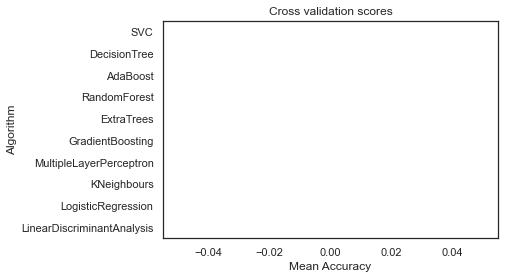

In [232]:
# Modeling step test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_results in cv_results:
    cv_means.append(cv_results.mean())
    cv_std.append(cv_results.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 'Algorithm': ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighbours', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

# 